In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import scipy.signal

# This package
import XNLdyn

%matplotlib notebook

import os
import pickle


In [2]:
load_dir = './simulation_results/30-06-2022_20-36/'
print(os.listdir(load_dir))

['save_dict.pi', 'raw_results.png', 'homogeneous_spectra.png', 'final_spectra.png', 'Input_spectrum.png']


In [3]:
with open(load_dir+'save_dict.pi','rb') as file:
    ld = pickle.load(file)
ld.keys()

dict_keys(['PAR', 'pulse_energy_max', 'N_local_fluences_to_calculate', 'load_spectrum_file', 'N_points_E', 'enax_abs', 'aufloesung', 'fl_dep_spectrum_I', 'fl_dep_spectrum_T', 'N_pulse_energies', 'final_pulse_energies', 'pulse_profile_sigma', 'Nsteps_r', 'final_incidence', 'final_incidence_peaks', 'final_transmissions'])

In [4]:
enax_abs = ld['enax_abs']
dE = enax_abs[1]-enax_abs[0]

In [5]:
aufloesung = np.sqrt((0.34/2.35)**2 + (0.48/2.35)**2) # Assuming 340 meV beamline and 4380 meV CHL, both FWHM converting to sigma


In [6]:
ld['PAR'].__dict__

{'kB': 8.617333262145e-05,
 'lightspeed': 299792458,
 'hbar': 6.582119569e-16,
 'echarge': 1.602176634e-19,
 'Nsteps_z': 20,
 'N_photens': 1,
 'N_j': 70,
 'timestep_min': 0.7,
 'Z': 20,
 'atomic_density': 91.4,
 'photon_bandwidth': 0.3,
 'temperature': 300,
 'DoS_band_origin': -10,
 'DoS_band_dd_end': 3.0,
 'M_core': 4,
 'R_VB_0': 10,
 'DoS_shapefile': './DoSdata.npy',
 'tau_CH': 1.37,
 'tau_th': 5,
 'tau_free': 15,
 'lambda_res_Ei': (30,),
 'lambda_nonres': 940,
 'E_f': 850.7,
 'mu_chem': 0,
 'T_0': 300,
 'I0_i': 13742.103386667379,
 't0_i': [0],
 'tdur_sig_i': array([13]),
 'E_i_abs': [851.5],
 'E_i': array([0.8]),
 'zstepsize': 1.0,
 'zaxis': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 'zedges': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 'E_j': array([-1.00000000e+01, -9.34375000e+00, -9.01562500e+00, -8.68750000e+00,
        -8.03

(848.0, 853.5)

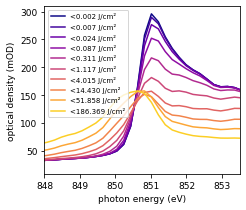

In [7]:
plt.rcParams.update({'font.size': 9})
fig = plt.figure(figsize =(3.5,3.))
plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,ld['N_pulse_energies']))#YlOrRd_r

for i in range(ld['N_pulse_energies'])[::]:
    spec = 1e3*np.log10(ld['final_incidence'][:,i]/ld['final_transmissions'][:,i])
    #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
    #plt.plot(enax_abs, spec, color = plotcols[i], lw=0.5)#, label ='For one z-stack'

    #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'
    fluence_J = ld['final_pulse_energies'][i]
    #{fluence_J*1e9:.3f} nJ,  
    lab =  f"<{1e14*ld['final_incidence_peaks'][i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0]):.3f} J/cm²"
    plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab)

plt.legend(fontsize = 7)
plt.xlabel('photon energy (eV)')
plt.ylabel('optical density (mOD)')
#plt.title('Spot reconstruction')
plt.tight_layout()
plt.xlim(848, 853.5)



In [8]:
# These are the pulse energies for which we evaluate stuff
set_final_pulse_energies = np.array([5.00000000e-12, 1.79690683e-11, 6.45774833e-11, 2.32079442e-10,
       8.34050269e-10, 2.99742125e-09, 1.07721735e-08, 3.87131841e-08,
       1.05e-07])#, 5.00000000e-07]
N_pulse_energies = len(set_final_pulse_energies)

fluences_joules_nm2, dA = XNLdyn.calculate_fluences(ld['Nsteps_r'], ld['pulse_energy_max'], ld['pulse_profile_sigma']) 

fluences_simulated_joules_nm2 = np.logspace(np.log10(np.min(fluences_joules_nm2*1e-2)),
                                 np.log10(np.max(fluences_joules_nm2)),
                                 ld['N_local_fluences_to_calculate'])

In [9]:
final_transmissions = np.zeros((ld['N_points_E'], N_pulse_energies))
final_incidence_check = np.zeros((ld['N_points_E'], N_pulse_energies))
final_incidence_peaks = np.zeros(N_pulse_energies)
for i_photen in range(ld['N_points_E']):

    for ipe, pulse_en in enumerate(set_final_pulse_energies):
        local_fluences, dA = XNLdyn.calculate_fluences(ld['Nsteps_r'], pulse_en, ld['pulse_profile_sigma'])
        
        
        local_transmitted = np.interp(local_fluences, fluences_simulated_joules_nm2,
                                      ld['fl_dep_spectrum_T'][i_photen,:])# tr[:, 0]
        final_transmissions[i_photen,ipe] = np.sum(local_transmitted*dA)

        
        local_incidence_check = np.interp(local_fluences, fluences_simulated_joules_nm2,
                                          ld['fl_dep_spectrum_I'][i_photen,:])

        final_incidence_check[i_photen,ipe] = np.sum(local_incidence_check*dA) # should result equal final_pulse_energies
        final_incidence_peaks[ipe] = np.max(local_incidence_check) 
        


<IPython.core.display.Javascript object>


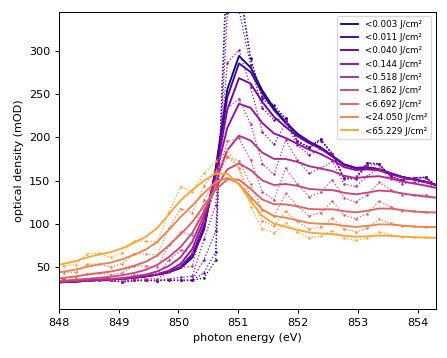

(2.0496434751601385, 345.0)

In [36]:
plt.rcParams.update({'font.size': 9})
fig = plt.figure(figsize =(5,4.))
plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,ld['N_pulse_energies']))#YlOrRd_r

for i in range(N_pulse_energies)[::]:
    spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
    #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
    #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'
 
    lab =  f"<{1e14*final_incidence_peaks[i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0]):.3f} J/cm²" 
    plt.plot(enax_abs, spec,'.:', ms=2, color = plotcols[i], lw=1)

    plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab)

plt.legend(fontsize = 7)
plt.xlabel('photon energy (eV)')
plt.ylabel('optical density (mOD)')
#plt.title('Spot reconstruction')
plt.tight_layout()
plt.xlim(848, 854.3)
plt.ylim(None, 345)


<IPython.core.display.Javascript object>


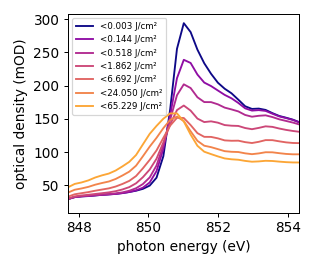

In [47]:
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize =(3.5,3.))
plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,ld['N_pulse_energies']))#YlOrRd_r

for i in range(N_pulse_energies):
    if i in [0,3,4,5,6,7,8]:
        spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
        #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
        spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
        #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'

        lab =  f"<{1e14*final_incidence_peaks[i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0]):.3f} J/cm²" 
        #plt.plot(enax_abs, spec,'.', ms=2, color = plotcols[i])

        plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab)

plt.legend(fontsize = 7)
plt.xlabel('photon energy (eV)')
plt.ylabel('optical density (mOD)')
#plt.title('Spot reconstruction')
plt.tight_layout()
plt.xlim(847.7, 854.3)
plt.savefig('plots/final_spectra.png')


## Quantification of effects:

* Pre-edge absorption
* Post-edge absorption
* Peak saturation
* Peak shift

<IPython.core.display.Javascript object>


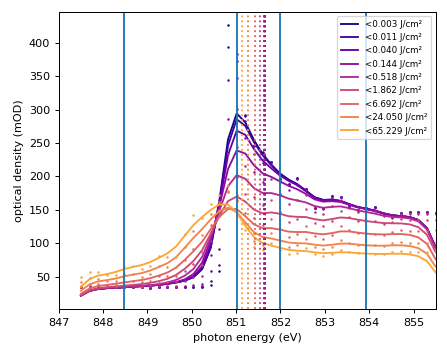

In [48]:
########### Repeat Plot
displayed_fluences = np.zeros(N_pulse_energies)

plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,ld['N_pulse_energies']))#YlOrRd_r

plt.rcParams.update({'font.size': 9})
fig = plt.figure(figsize =(5,4.))
for i in range(N_pulse_energies)[::]:
    spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
    #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
    #spec_sm =  sc.signal.savgol_filter(spec,9,3, mode='interp')
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
    #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'
    displayed_fluences[i]=1e14*final_incidence_peaks[i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0])
    lab =  f"<{displayed_fluences[i]:.3f} J/cm²" 
    
    plt.plot(enax_abs, spec,'.', ms=2, color = plotcols[i], lw=1)
    
    plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab)

plt.legend(fontsize = 7)
plt.xlabel('photon energy (eV)')
plt.ylabel('optical density (mOD)')
#plt.title('Spot reconstruction')
plt.tight_layout()
plt.xlim(847, 855.5)

############ Draw where to quantify stuff

pre_edge_en  = 848.5
on_edge_en   = 851
post_edge_en2 = 852
post_edge_en = 854

pre_edge_index  = np.argmin(np.abs(enax_abs-pre_edge_en))
on_edge_index   = np.argmin(np.abs(enax_abs-on_edge_en))
post_edge_index2 = np.argmin(np.abs(enax_abs-post_edge_en2))
post_edge_index = np.argmin(np.abs(enax_abs-post_edge_en))

plt.axvline(enax_abs[pre_edge_index])
plt.axvline(enax_abs[on_edge_index])
plt.axvline(enax_abs[post_edge_index2])
plt.axvline(enax_abs[post_edge_index])

pre_edge_intensities  = np.zeros(N_pulse_energies)
on_edge_intensities   = np.zeros(N_pulse_energies)
post_edge_intensities2 = np.zeros(N_pulse_energies)
post_edge_intensities = np.zeros(N_pulse_energies)

############ Extract Values
peak_center_weights = np.zeros(N_pulse_energies)

spectral_weight_from = 849
spectral_weight_to   = 853.5

def spectral_weight(x,y):
    return np.sum(y*x)/np.sum(y)

for i in range(N_pulse_energies)[::]:
    region = (enax_abs > spectral_weight_from) & (enax_abs < spectral_weight_to) # evaluate spectral weight in this region
    spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
    #spec_sm =  sc.signal.savgol_filter(spec,15,3, mode='interp')
    #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)

    # Spectral weight
    peak_center_weights[i] = spectral_weight(enax_abs[region],spec_sm[region])
    plt.axvline(peak_center_weights[i], color = plotcols[i], ls=':')
    
    pre_edge_intensities[i] = spec_sm[pre_edge_index]
    on_edge_intensities[i]  = spec_sm[on_edge_index]
    post_edge_intensities[i]= spec_sm[post_edge_index]
    post_edge_intensities2[i]= spec_sm[post_edge_index2]


## Import the experimental spectra

<IPython.core.display.Javascript object>


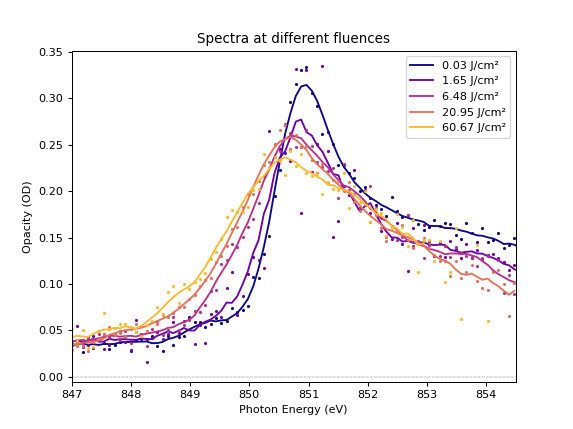

In [49]:
lde = np.load('Experimental_Spectra.npy',allow_pickle=True).item()

N_exp_fluences = len(lde['Indizes'])

exp_fluences  = np.zeros(N_exp_fluences)
exp_pre_edge_intensities  = np.zeros(N_exp_fluences)
exp_on_edge_intensities   = np.zeros(N_exp_fluences)
exp_post_edge_intensities = np.zeros(N_exp_fluences)
exp_post_edge_intensities2 = np.zeros(N_exp_fluences)
exp_peak_center_weights = np.zeros(N_exp_fluences)

exp_pre_edge_error  = np.zeros(N_exp_fluences)
exp_on_edge_error   = np.zeros(N_exp_fluences)
exp_post_edge_error = np.zeros(N_exp_fluences)
exp_post_edge_error2 = np.zeros(N_exp_fluences)

N = len(lde['Indizes'])
plotcols =  mpl.cm.plasma(np.linspace(.0,0.85,N))#YlOrRd_r


plt.figure()
#ax1 = plt.subplot2grid((5,1),(0,0),rowspan = 3)
#plt.sca(ax1)
plt.title('Spectra at different fluences')


spec1 = sc.signal.savgol_filter(lde[f'Spectrum{0}'],15,3, mode='interp')
for j,i in enumerate(lde['Indizes']):
    spec_sm =  sc.signal.savgol_filter(lde[f'Spectrum{i}'],15,3, mode='interp')
    #spec_sm = sc.ndimage.gaussian_filter(lde[f'Spectrum{i}'],aufloesung/dE)
    #spec_sm = XNLdyn.reconvolve(lde['Enax'],lde[f'Spectrum{i}'],aufloesung)
    errs =  sc.signal.savgol_filter(lde[f'Error{i}'],15,3, mode='interp')

    region = (lde['Enax'] > pre_edge_en) & (lde['Enax'] < post_edge_en) # evaluate spectral weight in this region

    exp_fluences[j] = lde[f'Fluence_mid{i}']
    exp_pre_edge_intensities[j] = np.interp(enax_abs[pre_edge_index],lde['Enax'],spec_sm)*1e3
    exp_on_edge_intensities[j] = np.interp(enax_abs[on_edge_index],lde['Enax'],spec_sm)*1e3
    exp_post_edge_intensities[j] = np.interp(enax_abs[post_edge_index],lde['Enax'],spec_sm)*1e3
    exp_post_edge_intensities2[j] = np.interp(enax_abs[post_edge_index2],lde['Enax'],spec_sm)*1e3

    exp_pre_edge_error[j] = np.interp(enax_abs[pre_edge_index],lde['Enax'],errs)*1e3
    exp_on_edge_error[j] = np.interp(enax_abs[on_edge_index],lde['Enax'],errs)*1e3
    exp_post_edge_error[j] = np.interp(enax_abs[post_edge_index],lde['Enax'],errs)*1e3
    exp_post_edge_error2[j] = np.interp(enax_abs[post_edge_index2],lde['Enax'],errs)*1e3

    exp_peak_center_weights[j] = spectral_weight(lde['Enax'][region],spec_sm[region])

    
    plt.plot(lde['Enax'], lde[f'Spectrum{i}'],'.',ms=3,c=plotcols[j])
    plt.plot(lde['Enax'],spec_sm,c=plotcols[j],\
             label = f"{exp_fluences[j]:.2f} J/cm²")
    
    

    
plt.axhline(0,c='k',lw=0.4,ls=':')
plt.xlim(847,854.5)
plt.ylabel('Opacity (OD)')
plt.xlabel('Photon Energy (eV)')
plt.legend()
####################


## Effect comparison to experiment

<IPython.core.display.Javascript object>


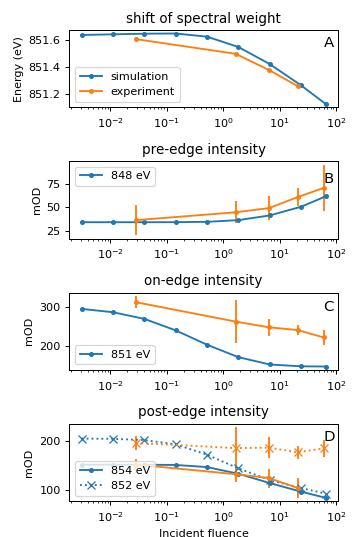

In [71]:
plt.figure(figsize = (4,6))
plt.subplot(4,1,1)
plt.title('shift of spectral weight')
plt.semilogx(displayed_fluences,peak_center_weights,'.-', label = 'simulation')
plt.semilogx(exp_fluences,exp_peak_center_weights,'.-', label = 'experiment')
plt.ylabel('Energy (eV)')
plt.text(60, 851.55,'A', fontsize = 12)
plt.legend()

plt.subplot(4,1,2)
plt.title('pre-edge intensity')
plt.plot(displayed_fluences,pre_edge_intensities,'.-',label = f'{pre_edge_en:.0f} eV')# label = 'simulation')
plt.errorbar(exp_fluences,exp_pre_edge_intensities,exp_pre_edge_error,marker='.')#, label = 'experiment')
plt.xscale('log')
plt.ylabel('mOD')
plt.text(60, 76,'B', fontsize = 12)
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.title('on-edge intensity')
plt.plot(displayed_fluences,on_edge_intensities,'.-', label = f'{on_edge_en:.0f} eV')
plt.errorbar(exp_fluences,exp_on_edge_intensities,exp_on_edge_error,marker='.')
plt.xscale('log')
plt.ylabel('mOD')
plt.text(60, 290,'C', fontsize = 12)
plt.legend(loc='lower left')

plt.subplot(4,1,4)
plt.title('post-edge intensity')
plt.plot(displayed_fluences,post_edge_intensities,'C0.-',  label = f'{post_edge_en:.0f} eV')
plt.plot(displayed_fluences,post_edge_intensities2,'C0x:', label = f'{post_edge_en2:.0f} eV')
plt.errorbar(exp_fluences,exp_post_edge_intensities,exp_post_edge_error, c='C1',marker='.')# 
plt.errorbar(exp_fluences,exp_post_edge_intensities2,exp_post_edge_error2, c='C1',marker='x', ls=':')#, label = f'{post_edge_en2:.0f} eV'
plt.xscale('log')
plt.ylabel('mOD')
plt.text(60, 200,'D', fontsize = 12)

plt.legend(loc='lower left')
plt.tight_layout()
plt.xlabel('Incident fluence')

plt.savefig('./plots/parameter_comparison.png')


In [42]:
aufloesung = np.sqrt((0.34/2.35)**2 + (0.48/2.35)**2) # Assuming 340 meV beamline and 4380 meV CHL, both FWHM converting to sigma


In [39]:
1e15 *20e-9 / 3e8

0.06666666666666667

In [44]:
aufloesung*2.35

0.5882176467941097